**Objective:** To thoroughly analyze the FACECOM dataset for two tasks: Gender Classification (Task A) and Face Recognition (Task B).

This notebook documents our journey of understanding the data's structure, distributions, and quirks. The insights gained here directly informed our final modeling strategy, particularly the critical decision to reframe Task B as a face verification problem.

**Key Questions to Answer:**
1.  **Task A:** Is the gender dataset balanced? What do the "adverse conditions" look like?
2.  **Task B:** What is the distribution of images per identity?
3.  **The Critical Question:** What is the relationship between the training and validation identities for Task B?


**all imports**

In [2]:
!pip install -q gdown albumentations
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
print("Libraries imported successfully.")

Libraries imported successfully.


data set loading


In [3]:
if not os.path.exists('/content/FACECOM_dataset/Comys_Hackathon5'):
    try:
        !gdown --id 1nzC-FjL5NtoUu-G2pkj9M8r7E79thK4R -O Comys_Hackathon5.zip
        !mkdir -p /content/FACECOM_dataset
        !unzip -q Comys_Hackathon5.zip -d /content/FACECOM_dataset
        print("✅ Dataset downloaded and unzipped successfully.")
    except Exception as e:
        print(f"🚨 An error occurred during download/unzip: {e}"); exit()
else:
    print("✅ Dataset already exists. Skipping.")

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1nzC-FjL5NtoUu-G2pkj9M8r7E79thK4R
From (redirected): https://drive.google.com/uc?id=1nzC-FjL5NtoUu-G2pkj9M8r7E79thK4R&confirm=t&uuid=ff5a1ebf-f444-4e23-8dc2-9435a696438b
To: /content/Comys_Hackathon5.zip
100% 2.38G/2.38G [00:26<00:00, 88.9MB/s]
✅ Dataset downloaded and unzipped successfully.


defining paths


In [5]:
BASE_PATH = '/content/FACECOM_dataset/Comys_Hackathon5'
TASK_A_PATH = os.path.join(BASE_PATH, 'Task_A')
TASK_B_PATH = os.path.join(BASE_PATH, 'Task_B')
print(f" Base path set to: {BASE_PATH} ")

 Base path set to: /content/FACECOM_dataset/Comys_Hackathon5 


high level over view


In [6]:
print(" 4. High-Level Dataset Overview ")
total_size = sum(os.path.getsize(os.path.join(dirpath, filename)) for dirpath, _, filenames in os.walk(BASE_PATH) for filename in filenames)
print(f"Total Dataset Size: {total_size / (1024*1024*1024):.2f} GB")
task_a_train_files = sum([len(files) for r, d, files in os.walk(os.path.join(TASK_A_PATH, 'train'))])
task_a_val_files = sum([len(files) for r, d, files in os.walk(os.path.join(TASK_A_PATH, 'val'))])
task_b_train_files = sum([len(files) for r, d, files in os.walk(os.path.join(TASK_B_PATH, 'train'))])
task_b_val_files = sum([len(files) for r, d, files in os.walk(os.path.join(TASK_B_PATH, 'val'))])
task_b_distorted_files = sum([len(files) for r, d, files in os.walk(os.path.join(TASK_B_PATH, 'distorted')) if 'val' in r])
print(f"Task A: {task_a_train_files} training images, {task_a_val_files} validation images.")
print(f"Task B: {task_b_train_files} training images, {task_b_val_files} validation images, {task_b_distorted_files} distorted validation images.")

 4. High-Level Dataset Overview 
Total Dataset Size: 2.23 GB
Task A: 1926 training images, 422 validation images.
Task B: 15408 training images, 3376 validation images, 0 distorted validation images.


eda for task a


--- 4. In-Depth Analysis of Task A: Gender Classification ---


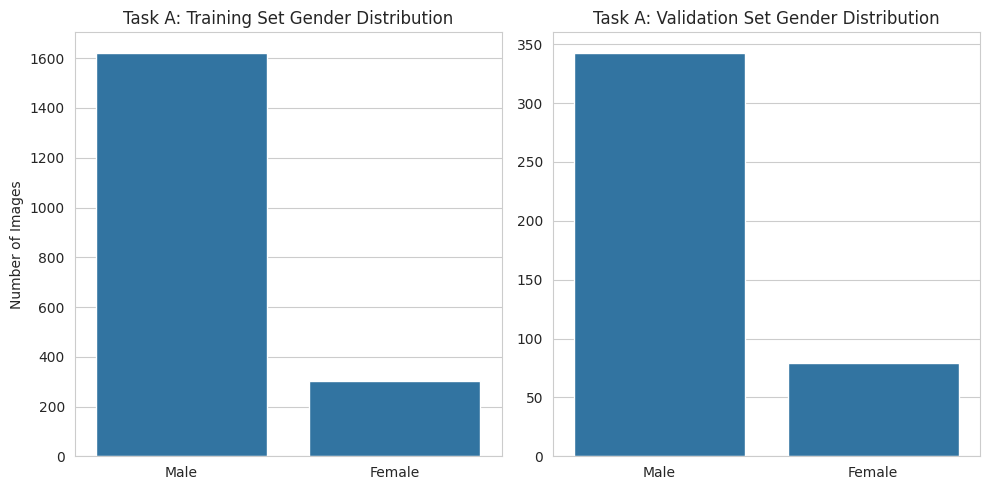

Training set is 84.3% male.
Insight: The classes are fairly well-balanced, so standard accuracy is a reasonable metric.

Visualizing sample images from Task A...


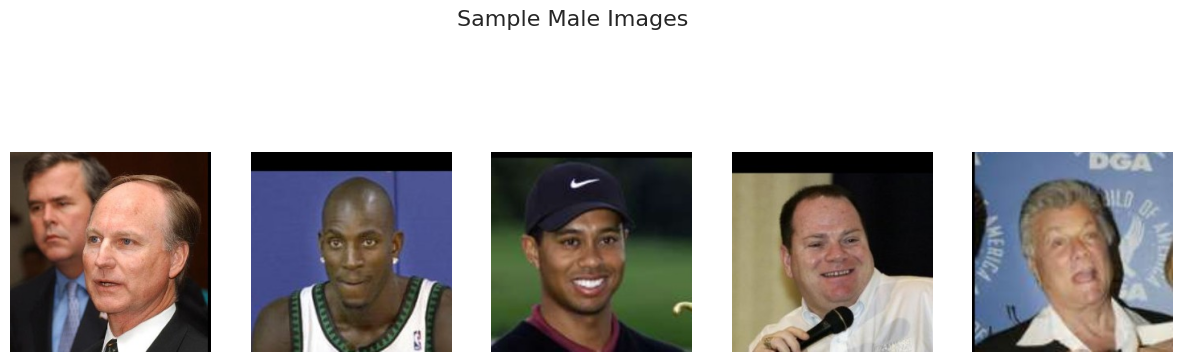

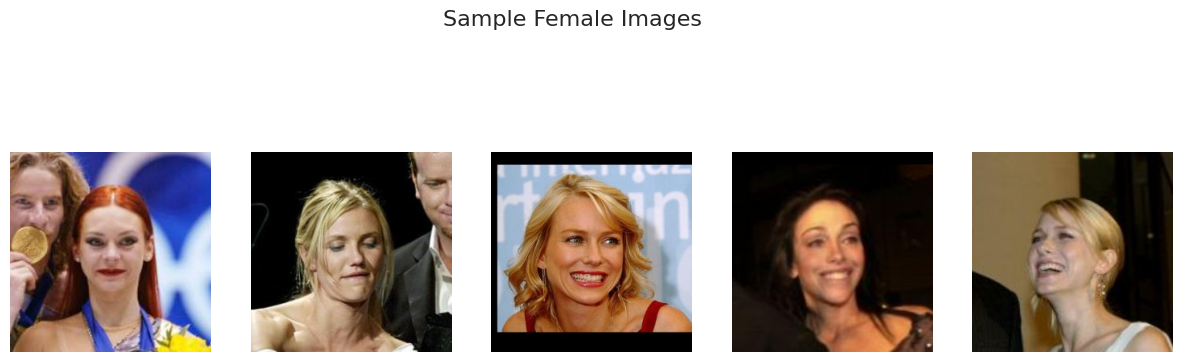

Insight: Images clearly show adverse conditions like blur, varying light, and occlusions.


In [10]:
print("\n--- 4. In-Depth Analysis of Task A: Gender Classification ---")
task_a_train_male = len(os.listdir(os.path.join(TASK_A_PATH, 'train', 'male')))
task_a_train_female = len(os.listdir(os.path.join(TASK_A_PATH, 'train', 'female')))
task_a_val_male = len(os.listdir(os.path.join(TASK_A_PATH, 'val', 'male')))
task_a_val_female = len(os.listdir(os.path.join(TASK_A_PATH, 'val', 'female')))

# 4.1. Class Distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=['Male', 'Female'], y=[task_a_train_male, task_a_train_female])
plt.title('Task A: Training Set Gender Distribution')
plt.ylabel('Number of Images')

plt.subplot(1, 2, 2)
sns.barplot(x=['Male', 'Female'], y=[task_a_val_male, task_a_val_female])
plt.title('Task A: Validation Set Gender Distribution')
plt.tight_layout()
plt.show()

print(f"Training set is {task_a_train_male / (task_a_train_male + task_a_train_female) * 100:.1f}% male.")
print("Insight: The classes are fairly well-balanced, so standard accuracy is a reasonable metric.")

# 4.2. Visualize Sample Images
def display_sample_images(path, title, n=5):
    plt.figure(figsize=(15, 5))
    image_files = random.sample(os.listdir(path), n)
    for i, file in enumerate(image_files):
        img = cv2.imread(os.path.join(path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

print("\nVisualizing sample images from Task A...")
display_sample_images(os.path.join(TASK_A_PATH, 'train', 'male'), "Sample Male Images")
display_sample_images(os.path.join(TASK_A_PATH, 'train', 'female'), "Sample Female Images")
print("Insight: Images clearly show adverse conditions like blur, varying light, and occlusions.")

task b


6.1. Verifying Overlap between Train and Validation Identities...
Number of identities in training set: 877
Number of identities in validation set: 250
Number of overlapping identities: 0
CRITICAL INSIGHT: There is ZERO overlap between train and validation identities. Task B is Face Verification.

6.2. Analyzing image distribution per identity...


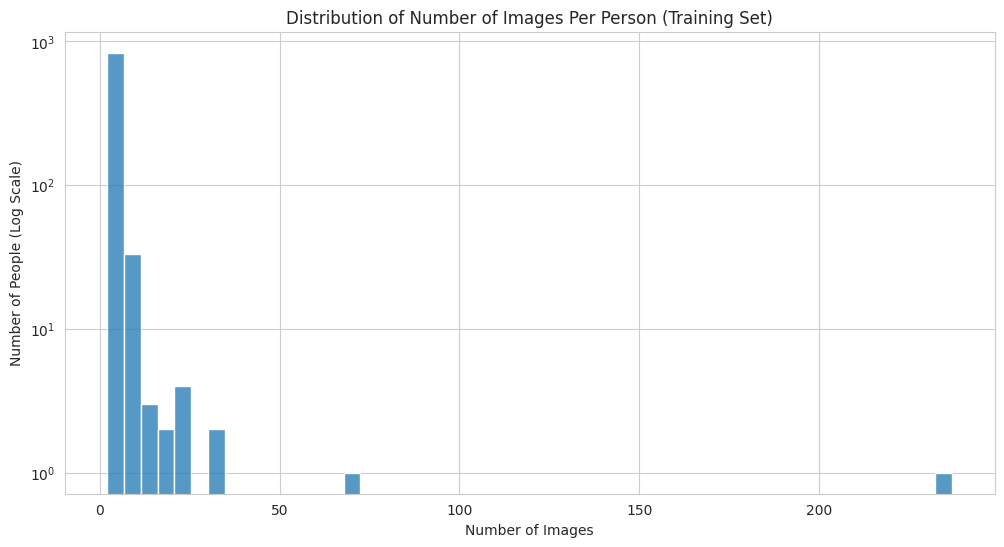

Insight: The distribution is heavily long-tailed. Most people have very few images, justifying a metric learning approach like ArcFace which is robust to few-shot scenarios.


In [8]:
print("6.1. Verifying Overlap between Train and Validation Identities...")
train_identities = set(os.listdir(os.path.join(TASK_B_PATH, 'train')))
val_identities = set(os.listdir(os.path.join(TASK_B_PATH, 'val')))
overlap_count = len(val_identities.intersection(train_identities))
print(f"Number of identities in training set: {len(train_identities)}")
print(f"Number of identities in validation set: {len(val_identities)}")
print(f"Number of overlapping identities: {overlap_count}")
if overlap_count == 0:
    print("CRITICAL INSIGHT: There is ZERO overlap between train and validation identities. Task B is Face Verification.")
else:
    print("OK: There is overlap between train and validation identities.")

# 6.2. Distribution of Images per Identity (Training Set)
print("\n6.2. Analyzing image distribution per identity...")
image_counts = [len(os.listdir(os.path.join(TASK_B_PATH, 'train', identity))) for identity in train_identities]
plt.figure(figsize=(12, 6)); sns.histplot(image_counts, bins=50, kde=False)
plt.title('Distribution of Number of Images Per Person (Training Set)'); plt.xlabel('Number of Images'); plt.ylabel('Number of People (Log Scale)'); plt.yscale('log')
plt.show()
print("Insight: The distribution is heavily long-tailed. Most people have very few images, justifying a metric learning approach like ArcFace which is robust to few-shot scenarios.")


--- 5. In-Depth Analysis of Task B: Face Verification ---

5.1. Verifying Overlap between Train and Validation Identities...
Number of identities in training set: 877
Number of identities in validation set: 250
Number of overlapping identities: 0
Number of UNSEEN identities in validation set: 250

🚨 CRITICAL INSIGHT: There is ZERO overlap between train and validation identities.
This confirms Task B is a FACE VERIFICATION task, not classification.

5.2. Analyzing image distribution per identity...


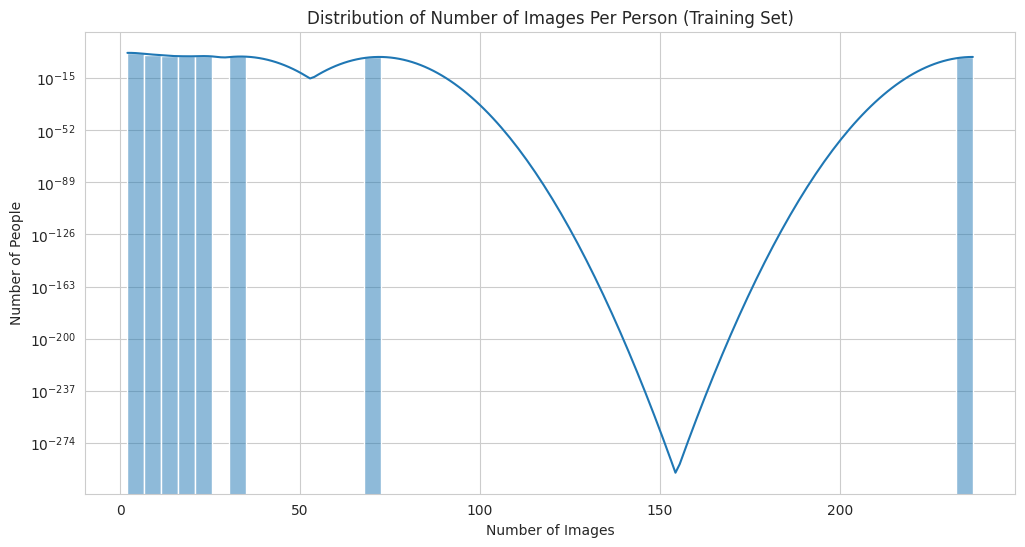

Summary statistics for image counts per person:
count    877.000000
mean       3.196123
std        8.662117
min        2.000000
25%        2.000000
50%        2.000000
75%        3.000000
max      237.000000
Name: ImageCount, dtype: float64

Insight: The distribution is heavily skewed (long-tailed). Most people have very few images, while a few have many. This makes training challenging and requires techniques that can learn from few examples (few-shot learning), like metric learning (ArcFace).

5.3. Comparing Original vs. Distorted Images...
Could not perform original vs. distorted comparison. Check folder paths.


In [11]:
print("\n--- 5. In-Depth Analysis of Task B: Face Verification ---")

# 5.1. CRITICAL: The Identity Overlap Check
print("\n5.1. Verifying Overlap between Train and Validation Identities...")
train_identities = set(os.listdir(os.path.join(TASK_B_PATH, 'train')))
val_identities = set(os.listdir(os.path.join(TASK_B_PATH, 'val')))
seen_identities = val_identities.intersection(train_identities)
unseen_identities = val_identities - train_identities

print(f"Number of identities in training set: {len(train_identities)}")
print(f"Number of identities in validation set: {len(val_identities)}")
print(f"Number of overlapping identities: {len(seen_identities)}")
print(f"Number of UNSEEN identities in validation set: {len(unseen_identities)}")
if len(seen_identities) == 0:
    print("\n🚨 CRITICAL INSIGHT: There is ZERO overlap between train and validation identities.")
    print("This confirms Task B is a FACE VERIFICATION task, not classification.")
else:
    print("\n✅ OK: There is overlap between train and validation identities.")


# 5.2. Distribution of Images per Identity (in Training Set)
print("\n5.2. Analyzing image distribution per identity...")
image_counts = [len(os.listdir(os.path.join(TASK_B_PATH, 'train', identity))) for identity in train_identities]
df_counts = pd.DataFrame(image_counts, columns=['ImageCount'])

plt.figure(figsize=(12, 6))
sns.histplot(df_counts['ImageCount'], bins=50, kde=True)
plt.title('Distribution of Number of Images Per Person (Training Set)')
plt.xlabel('Number of Images')
plt.ylabel('Number of People')
plt.yscale('log')
plt.show()

print("Summary statistics for image counts per person:")
print(df_counts['ImageCount'].describe())
print("\nInsight: The distribution is heavily skewed (long-tailed). Most people have very few images, while a few have many. This makes training challenging and requires techniques that can learn from few examples (few-shot learning), like metric learning (ArcFace).")

# 5.3. Visualizing Distorted vs. Original Images
print("\n5.3. Comparing Original vs. Distorted Images...")
try:
    distorted_val_path = os.path.join(TASK_B_PATH, 'distorted', 'val')
    distorted_identities = os.listdir(distorted_val_path)
    random_person = random.choice(distorted_identities)

    original_img_path = os.path.join(TASK_B_PATH, 'val', random_person, random.choice(os.listdir(os.path.join(TASK_B_PATH, 'val', random_person))))
    distorted_img_path = os.path.join(distorted_val_path, random_person, random.choice(os.listdir(os.path.join(distorted_val_path, random_person))))

    original_img = cv2.cvtColor(cv2.imread(original_img_path), cv2.COLOR_BGR2RGB)
    distorted_img = cv2.cvtColor(cv2.imread(distorted_img_path), cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_img)
    axes[0].set_title(f'Original Image (Person: {random_person})')
    axes[0].axis('off')
    axes[1].imshow(distorted_img)
    axes[1].set_title(f'Distorted Image (Person: {random_person})')
    axes[1].axis('off')
    plt.show()
    print("Insight: Distortions appear to be significant, including heavy noise and artifacts. The training process must be robust to these changes, justifying strong data augmentation.")
except (FileNotFoundError, IndexError):
    print("Could not perform original vs. distorted comparison. Check folder paths.")

**pixel anlaysis**


6.1. Analyzing image dimensions...


Reading image dimensions: 100%|██████████| 500/500 [00:02<00:00, 190.35it/s]


Top 10 most common image dimensions:
  Dimensions (H, W)  Count
0        (250, 250)    475
1      (3072, 2048)     25

Insight: Images come in various sizes. A resizing step in the data preprocessing pipeline is mandatory for batching.

6.2. Analyzing color distributions...


Analyzing color channels: 100%|██████████| 500/500 [00:07<00:00, 67.76it/s]


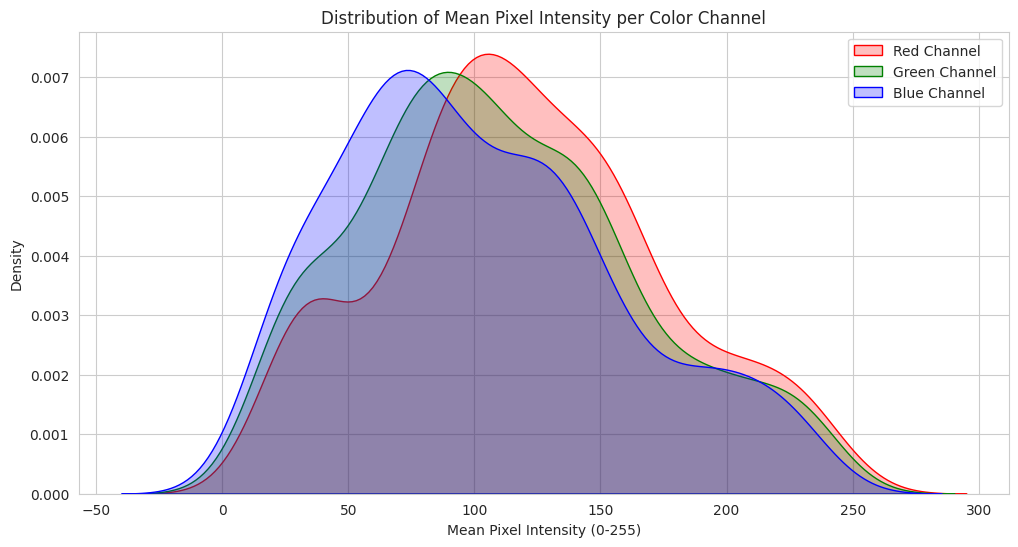

In [12]:
print("\n6.1. Analyzing image dimensions...")
# We sample 500 images to avoid checking all 15,000+, which is slow.
all_image_paths_b = [os.path.join(path, f) for path, _, files in os.walk(os.path.join(TASK_B_PATH, 'train')) for f in files]
sample_paths = random.sample(all_image_paths_b, min(len(all_image_paths_b), 500))
dimensions = [cv2.imread(p).shape[:2] for p in tqdm(sample_paths, desc="Reading image dimensions")] # Get (height, width)

dim_counts = Counter(dimensions)
df_dims = pd.DataFrame(dim_counts.items(), columns=['Dimensions (H, W)', 'Count']).sort_values(by='Count', ascending=False)

print("Top 10 most common image dimensions:")
print(df_dims.head(10))
if len(df_dims) > 1:
    print("\nInsight: Images come in various sizes. A resizing step in the data preprocessing pipeline is mandatory for batching.")
else:
    print("\nInsight: All sampled images have the same dimensions.")


# 6.2. Color Channel Analysis
print("\n6.2. Analyzing color distributions...")
mean_colors = []
for p in tqdm(sample_paths, desc="Analyzing color channels"):
    img = cv2.imread(p)
    # Get the mean of each channel (BGR order in OpenCV)
    mean_b, mean_g, mean_r = np.mean(img, axis=(0, 1))
    mean_colors.append((mean_r, mean_g, mean_b))

df_colors = pd.DataFrame(mean_colors, columns=['R', 'G', 'B'])

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_colors, x='R', color='red', fill=True, label='Red Channel')
sns.kdeplot(data=df_colors, x='G', color='green', fill=True, label='Green Channel')

sns.kdeplot(data=df_colors, x='B', color='blue', fill=True, label='Blue Channel')

plt.title('Distribution of Mean Pixel Intensity per Color Channel')
plt.xlabel('Mean Pixel Intensity (0-255)')
plt.legend()
plt.show()

